<a href="https://colab.research.google.com/github/AlexYiningLiu/UNet_Face_Segmentation/blob/main/face_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os 
import zipfile
import random
import pandas as pd 
import cv2

In [26]:
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

# Data Loading and Processing

In [3]:
df = pd.read_pickle('/content/drive/My Drive/Datasets/annotation.pkl')
print(df)

       ImageEyesGazeDirection_0  ...  ImageEyesHeadDirection_1
00000                 -0.203216  ...                  0.046461
00001                  0.945687  ...                  0.808736
00002                 -0.414811  ...                 -0.061110
00003                 -0.976813  ...                 -0.301131
00004                  0.980972  ...                 -0.182908
...                         ...  ...                       ...
03995                 -0.650791  ...                  0.576683
03996                  0.990405  ...                 -0.763386
03997                 -0.745241  ...                 -0.034462
03998                 -0.227230  ...                  0.983453
03999                 -0.157115  ...                  0.656179

[4000 rows x 4 columns]


In [4]:
raw_dir = '/content/drive/My Drive/Datasets/Unzipped/output/lit'
seg_dir = '/content/drive/My Drive/Datasets/Unzipped/output/segmentation'

In [5]:
raw_images = np.load('/content/drive/My Drive/Datasets/raw_imgs.npy')
print(raw_images.shape)

(4000, 256, 256, 3)


**Produce np file from segmentation masks**

Only use the face color mask. Ignore the other masks

In [ ]:
images = []
face_color = (205, 158, 0)
for index, i in enumerate(df.index.values):
    image_path = os.path.join(seg_dir, i+'.png')
    image = cv2.imread(image_path)
    image = image[:, 80:560]
    image = cv2.resize(image, (256, 256))
    mask = np.zeros(image.shape[:2], dtype=bool)
    mask |= (image == face_color).all(-1)
    image[mask] = (255, 255, 255)
    image[~mask] = (0,0,0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images.append(image)
    if index%100==0:
        print("Image number: %d" %index)
images = np.array(images)

In [37]:
np.save('/content/drive/My Drive/Datasets/face_masks.npy', images)

In [ ]:
segmentation_images = np.load('/content/drive/My Drive/Datasets/segmentation_imgs.npy')
print(segmentation_images.shape)

(4000, 256, 256, 3)


In [4]:
face_mask_images = np.load('/content/drive/My Drive/Datasets/face_masks.npy')
print(face_mask_images.shape)

(4000, 256, 256)


In [6]:
np.random.seed(100)
shuffle_ids = np.array([i for i in range(4000)])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(4000*0.8)]
val_ids = shuffle_ids[int(4000*0.8):int(4000*0.8+400)]
test_ids = shuffle_ids[int(4000*0.8+400):]

In [7]:
train_images, train_masks = raw_images[train_ids], face_mask_images[train_ids]
val_images, val_masks = raw_images[val_ids], face_mask_images[val_ids]
test_images, test_masks = raw_images[test_ids], face_mask_images[test_ids]

In [10]:
print(train_images.shape, val_images.shape, test_images.shape)

(3200, 256, 256, 3) (400, 256, 256, 3) (400, 256, 256, 3)


In [8]:
train_masks = train_masks / train_masks.max()

In [10]:
val_masks = val_masks / val_masks.max()

In [11]:
del raw_images
del face_mask_images

# Hyperparameter Setup

In [23]:
BATCH_SIZE = 16 
EPOCHS = 60
# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 10

SHAPE = (256, 256, 3)

# Number of classes
NUM_CLASSES = 2

AUTO = tf.data.experimental.AUTOTUNE

CLASSES = {0:'Background', 1:'Face'}

# Model Construction

In [13]:
def getModel():
    
    # Use the TPU strategy
    #with tpu_strategy.scope():
        
    # Build the model
    input_img = Input((SHAPE[0], SHAPE[1], 3), name='img')

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
    u5 = concatenate([u5, c3])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

    model = Model(inputs=[input_img], 
                    outputs=[outputs])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model

In [29]:
model = getModel()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 8)  584         conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_16[0][0]                  
____________________________________________________________________________________________

In [32]:
callbacks = [
    EarlyStopping(patience=STOPPING_PATIENCE, verbose=1),
    ReduceLROnPlateau(patience=LR_PATIENCE, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/Datasets/model_face_seg_v1.h5', verbose=1, save_best_only=True)
]

In [33]:
results = model.fit(train_images, train_masks, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks,
                    validation_data=(val_images, val_masks))

Epoch 1/60
200/200 [==============================] - 16s 82ms/step - loss: 0.0556 - accuracy: 0.9750 - val_loss: 0.0446 - val_accuracy: 0.9804

Epoch 00001: val_loss improved from inf to 0.04460, saving model to /content/drive/My Drive/Datasets/model_face_seg_v1.h5
Epoch 2/60
200/200 [==============================] - 16s 82ms/step - loss: 0.0406 - accuracy: 0.9824 - val_loss: 0.0346 - val_accuracy: 0.9852

Epoch 00002: val_loss improved from 0.04460 to 0.03461, saving model to /content/drive/My Drive/Datasets/model_face_seg_v1.h5
Epoch 3/60
200/200 [==============================] - 16s 82ms/step - loss: 0.0331 - accuracy: 0.9859 - val_loss: 0.0301 - val_accuracy: 0.9872

Epoch 00003: val_loss improved from 0.03461 to 0.03012, saving model to /content/drive/My Drive/Datasets/model_face_seg_v1.h5
Epoch 4/60
200/200 [==============================] - 16s 81ms/step - loss: 0.0292 - accuracy: 0.9877 - val_loss: 0.0264 - val_accuracy: 0.9889

Epoch 00004: val_loss improved from 0.03012 to

Text(0.5, 1.0, 'Ground truth')

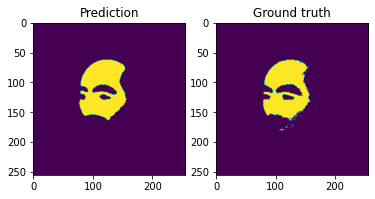

In [21]:
NUMBER = 19

my_preds = model.predict(np.expand_dims(test_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(256, 256))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(256, 256))
ax[1].set_title('Ground truth')